In [64]:
#!/usr/bin/env python
import matplotlib
%matplotlib inline 
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from __future__ import print_function
import argparse

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

from links import world

import numpy as np

try:
    from tqdm import tqdm
except:
    tqdm = list

import json

In [2]:
def generate_(model, data, train=False, printer=False):
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt
    prev_train = model.train
    model.train = train
    sentence_history, log_prob_history, canvas_history = model(data, generate=True)
    canvas_history = [c * 255 for c in canvas_history]
    true_image = data * 255
    model.train = prev_train

    def save_images(x, filename):
        x = np.array(x.tolist(), np.float32)
        width = x.shape[0]
        fig, ax = plt.subplots(1, width, figsize=(1*width, 1))#, dpi=20)
        for ai, xi in zip(ax.ravel(), x):
            ai.imshow(xi.reshape(28, 28), cmap='Greys_r')
        #fig.savefig(filename)

    for i in range(model.n_turn):
        save_images(canvas_history[i], str(train)+'{}.png'.format(i))
        #np.save(str(train)+'{}.npz'.format(i), np.array(canvas_history[i].tolist()))
        #if printer: print('save {}.png'.format(i))
    save_images(true_image.data, str(train)+'_.png')
    
    for i in range(data.shape[0]):
        for log_prob_batch, word_batch_list in zip(log_prob_history, sentence_history):
            if printer: print(str(i)+",\t", [int(word_batch[i]) for word_batch in word_batch_list], log_prob_batch[i])
        """
        save_target = [
            [
                [[int(word[i]) for word in sent] for sent in sentence_history],
                [float(lpb[i]) for lpb in log_prob_history]
            ]
            for i in range(data.shape[0])]
        """
    #json.dump(save_target, open(str(train)+'seq.json', 'w'))

In [24]:
def generate_data(model, data, train=False, printer=False):
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt
    prev_train = model.train
    model.train = train
    sentence_history, log_prob_history, canvas_history = model(data, generate=True)
    canvas_history = [c * 255 for c in canvas_history]
    true_image = data * 255
    model.train = prev_train

    def save_images(x, filename):
        x = np.array(x.tolist(), np.float32)
        width = x.shape[0]
        fig, ax = plt.subplots(1, width, figsize=(1*width, 1))#, dpi=20)
        for a in ax:
            a.set_xticklabels([])
            a.set_yticklabels([])
        for ai, xi in zip(ax.ravel(), x):
            ai.imshow(xi.reshape(28, 28), cmap='Greys_r')
        #fig.savefig(filename)

    for i in range(model.n_turn):
        save_images(canvas_history[i], str(train)+'{}.png'.format(i))
        #np.save(str(train)+'{}.npz'.format(i), np.array(canvas_history[i].tolist()))
        #if printer: print('save {}.png'.format(i))
    save_images(true_image.data, str(train)+'_.png')
    
    for i in range(data.shape[0]):
        for log_prob_batch, word_batch_list in zip(log_prob_history, sentence_history):
            if printer: print(str(i)+",\t", [int(word_batch[i]) for word_batch in word_batch_list], log_prob_batch[i])
        """
        save_target = [
            [
                [[int(word[i]) for word in sent] for sent in sentence_history],
                [float(lpb[i]) for lpb in log_prob_history]
            ]
            for i in range(data.shape[0])]
        """
    #json.dump(save_target, open(str(train)+'seq.json', 'w'))

In [45]:
def generate(model, message, printer=True):
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt
    prev_train = model.train
    model.train = False

    batchsize = message.shape[1]
    shape = (batchsize, 784)
    
    sentence_history = [message]
    log_prob_history = [np.zeros((batchsize,1))]
    
    canvas_history = model.generate(message, shape)
    canvas_history = [c * 255 for c in canvas_history]
    model.train = prev_train

    def save_images(x, filename):
        x = np.array(x.tolist(), np.float32)
        width = x.shape[0]
        fig, ax = plt.subplots(1, width, figsize=(1*width, 1))#, dpi=20)
        if width == 1:
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.imshow(x.reshape(28, 28), cmap='Greys_r')
        else:
            for a in ax:
                a.set_xticklabels([])
                a.set_yticklabels([])
            for ai, xi in zip(ax.ravel(), x):
                ai.imshow(xi.reshape(28, 28), cmap='Greys_r')
        #if saver:
        #    fig.savefig(filename)

    for i in range(model.n_turn):
        save_images(canvas_history[i], str(train)+'{}.png'.format(i))
        #np.save(str(train)+'{}.npz'.format(i), np.array(canvas_history[i].tolist()))
        #if printer: print('save {}.png'.format(i))
    
    for i in range(batchsize):
        for log_prob_batch, word_batch_list in zip(log_prob_history, sentence_history):
            if printer: print(str(i)+",\t", [int(word_batch[i]) for word_batch in word_batch_list], log_prob_batch[i])


In [46]:
#model = world.World(28 * 28, 256, 256, n_vocab=32, n_word=2, n_turn=3)
args = {}
args['image_unit'] = 256
args['unit'] = 16
args['vocab'] = 2
args['word'] = 10
args['turn'] = 1
args['drop_ratio'] = 0.2
args['co_importance'] = 0
args['co_orthogonal'] = 0
model = world.World(
        28 * 28, args['image_unit'], args['unit'],
        n_vocab=args['vocab'], n_word=args['word'], n_turn=args['turn'],
        drop_ratio=args['drop_ratio'], co_importance=args['co_importance'],
        co_orthogonal=args['co_orthogonal'])
train, test = chainer.datasets.get_mnist(withlabel=False)
import chainer.serializers as S
#S.load_npz('../saved_model.model', model)
S.load_npz('../data0306/test_ort1e-2imp1e-2w10t1b512iu256u16d02v2/saved_model.model', model)

to (1, 1, 1, 1, 1, 1, 1, 1, 1, 1)


/home/sosuke.k/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


"\nmessage = np.array([\n            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n            [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],\n            [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],\n            [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],\n            [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],\n            [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],\n            [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],\n            [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],\n    ]).astype('i').T\n"

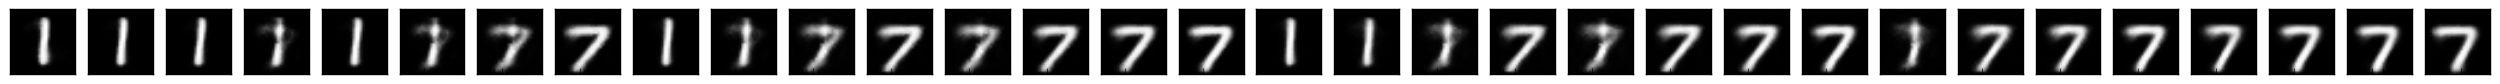

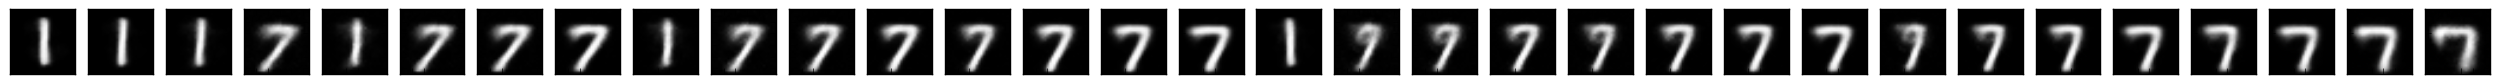

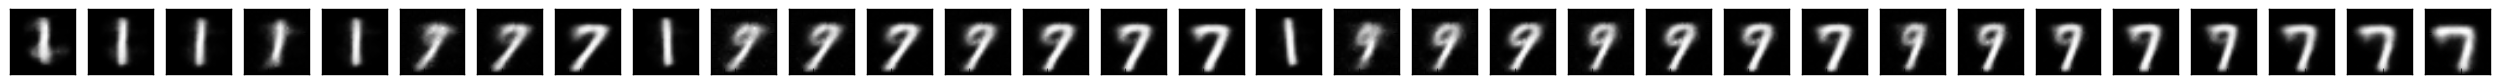

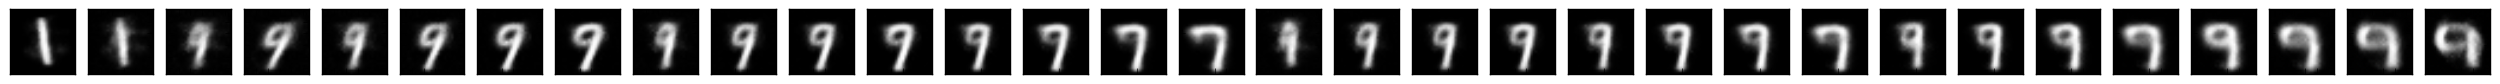

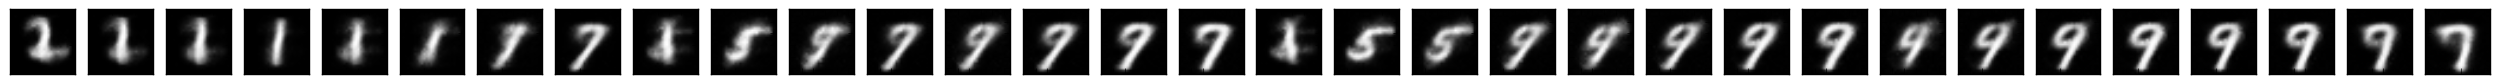

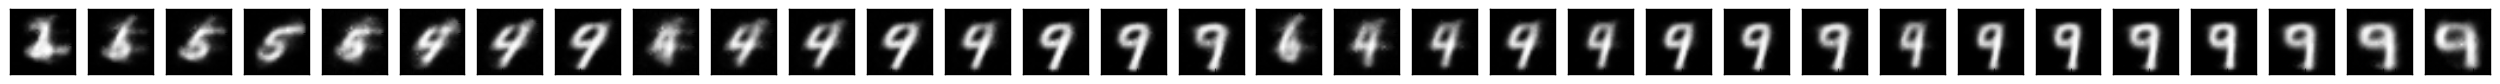

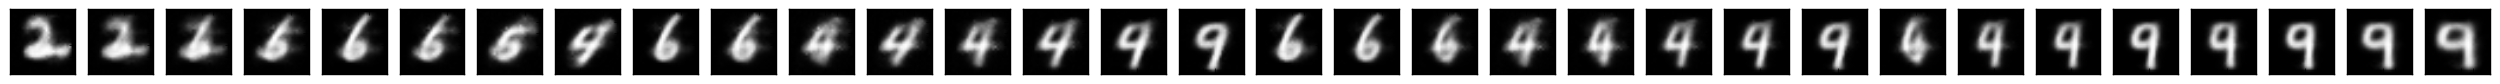

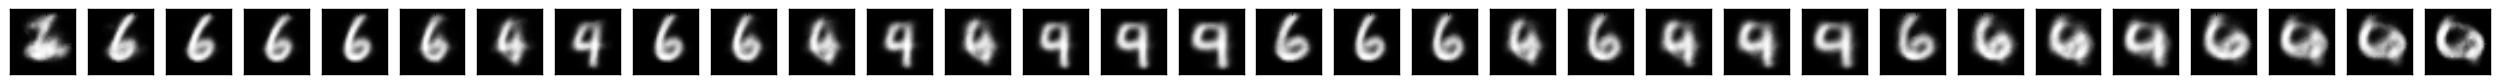

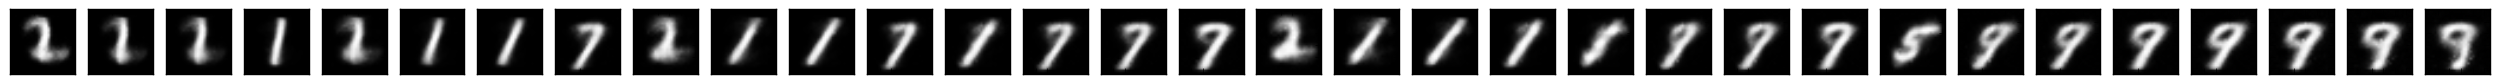

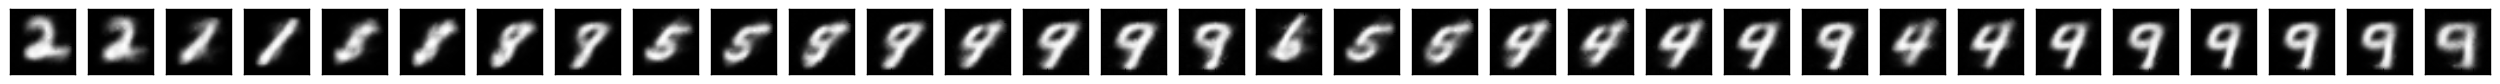

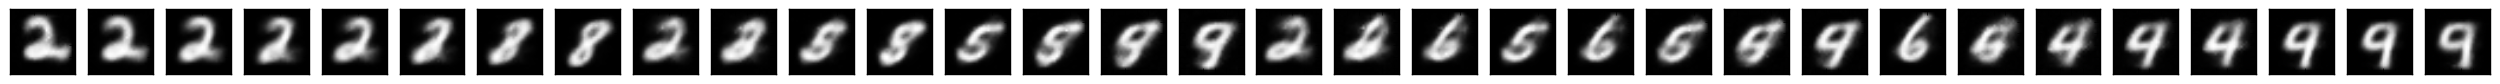

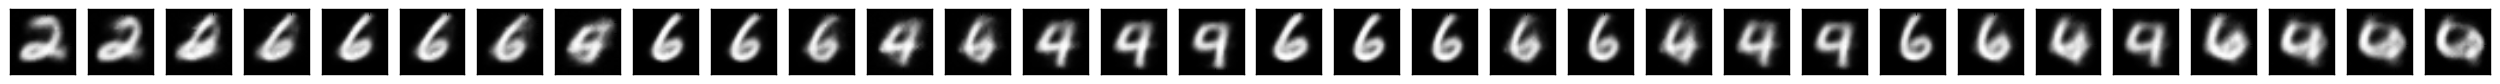

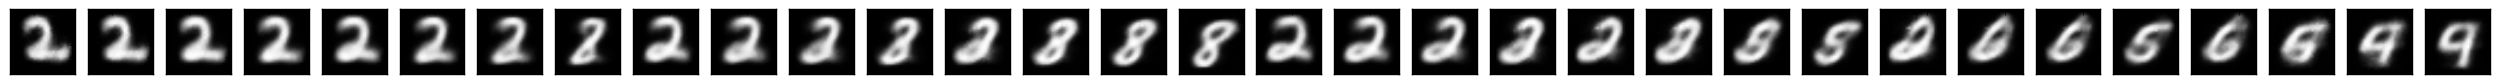

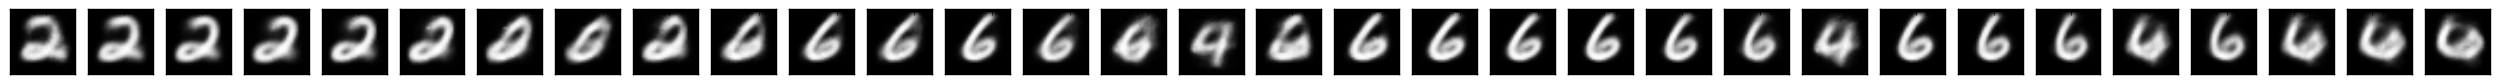

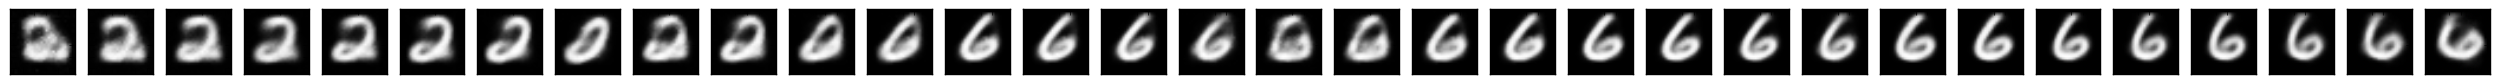

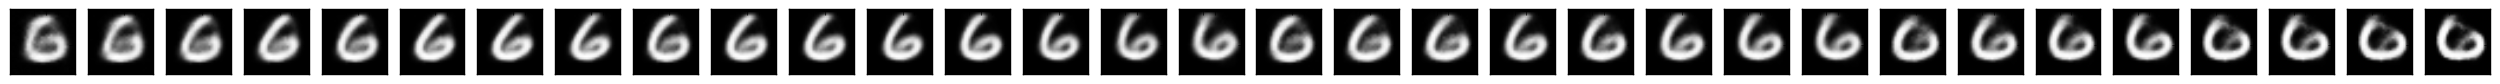

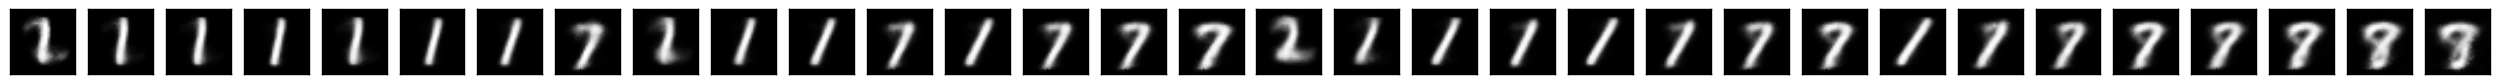

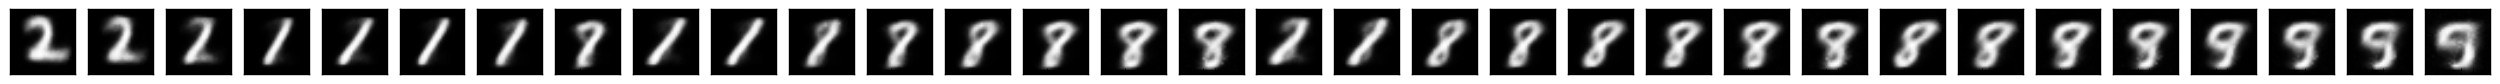

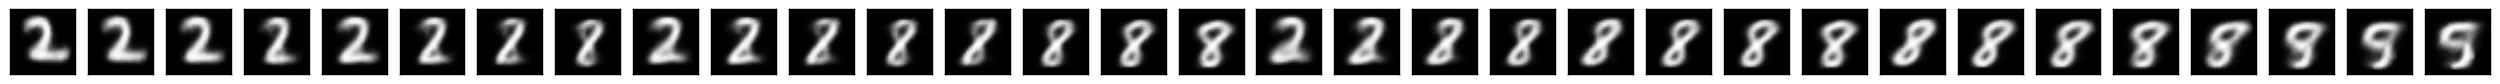

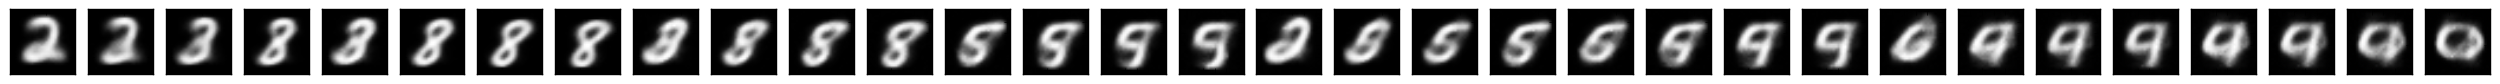

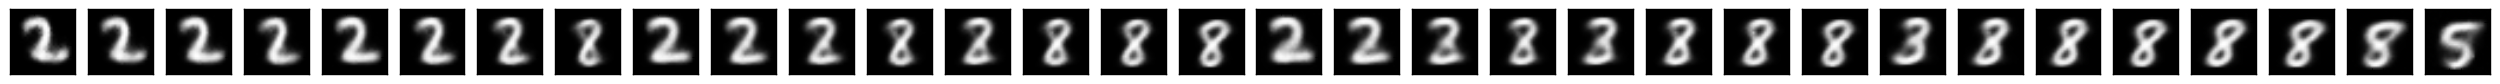

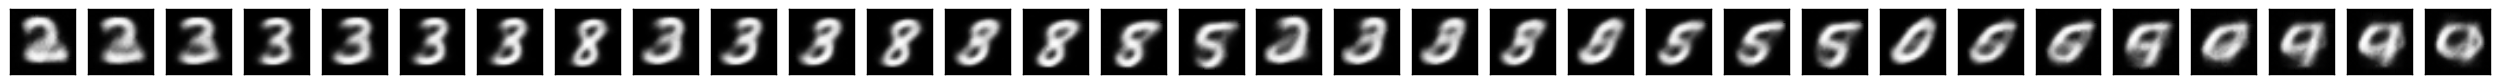

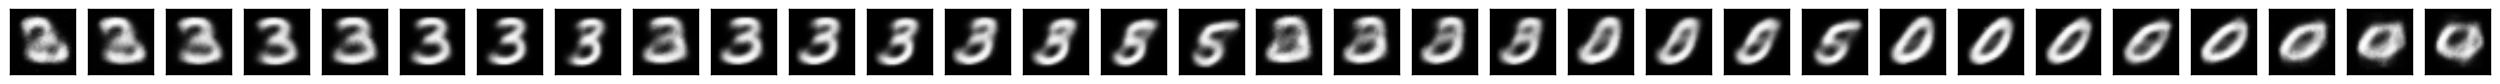

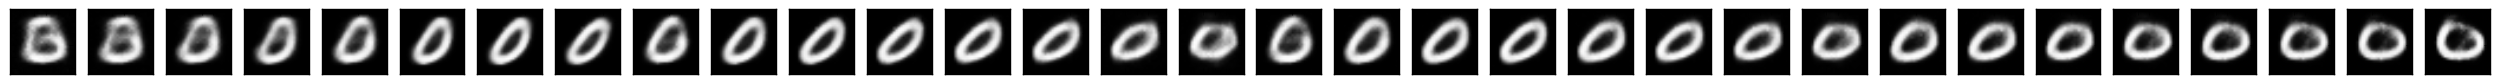

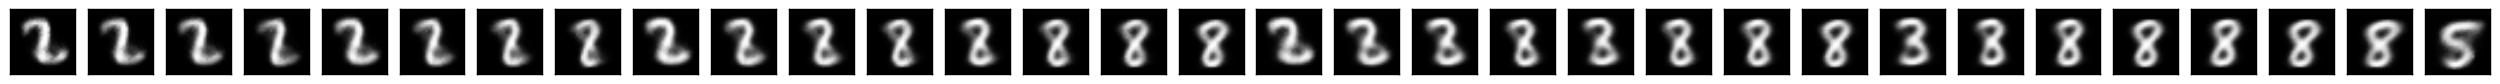

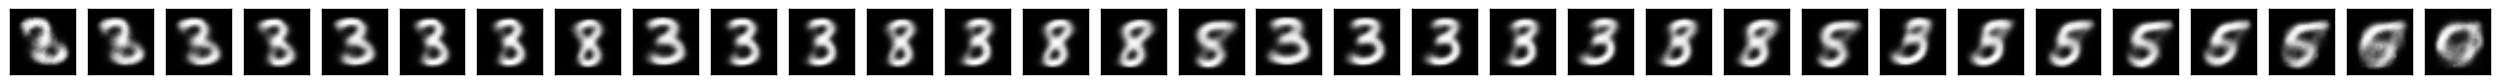

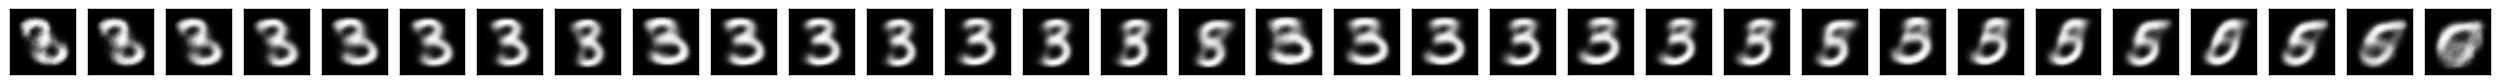

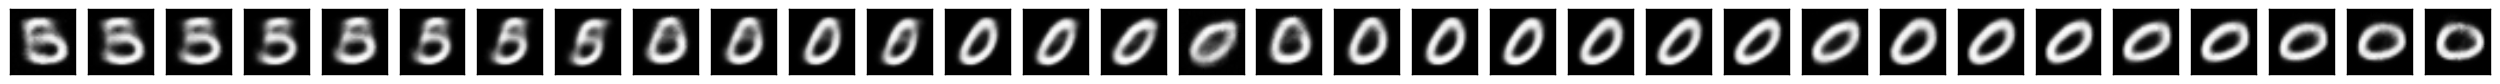

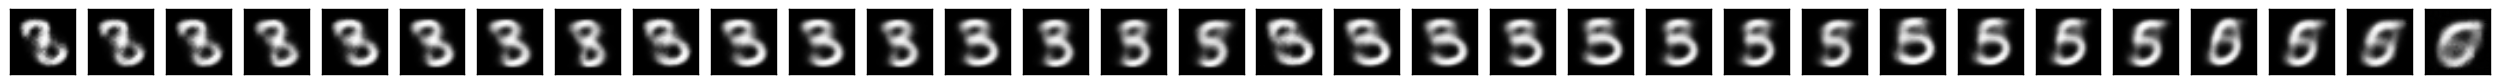

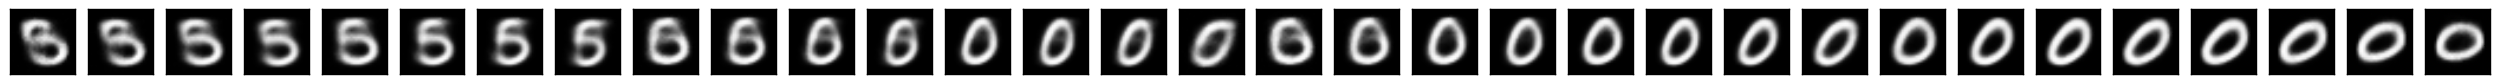

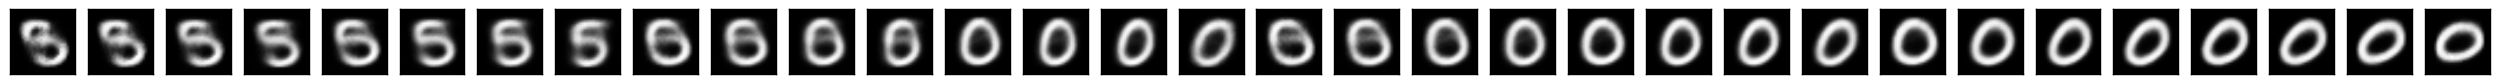

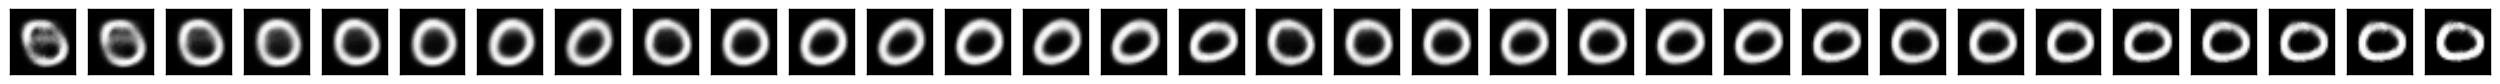

In [62]:
'''
convert = chainer.dataset.convert.concat_examples
d = convert(test[:10])
d = chainer.Variable(model.xp.array(d.tolist(), np.float32), volatile='auto')
generate_data(model, d, train=False, printer=True)
'''
plt.clf()
plt.close('all')
#message = np.array([0, 0, 0, 0, 0, 1, 1, 1, 0, 1]).astype('i')[:, None]
#generate(model, message)
import itertools
all_message = list(sorted(itertools.product([0, 1], repeat=10)))
print('to', all_message[-1])
ran = len(all_message) // 32
for i in range(ran):
    message = all_message[len(all_message)//ran*i: len(all_message)//ran*(i+1)]
    message = np.array(message).astype('i').T
    generate(model, message, printer=False)

"""
message = np.array([
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
            [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
    ]).astype('i').T
"""
#generate(model, message)

#message = 1 - message
#generate(model, message)

to [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


"\nmessage = np.array([\n            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n            [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],\n            [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],\n            [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],\n            [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],\n            [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],\n            [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],\n            [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],\n    ]).astype('i').T\n"

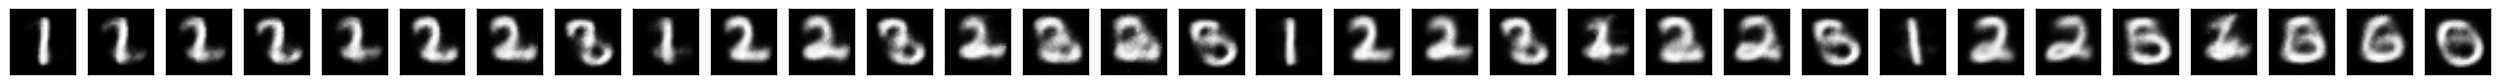

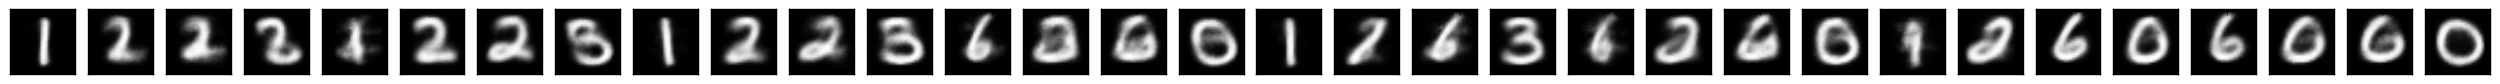

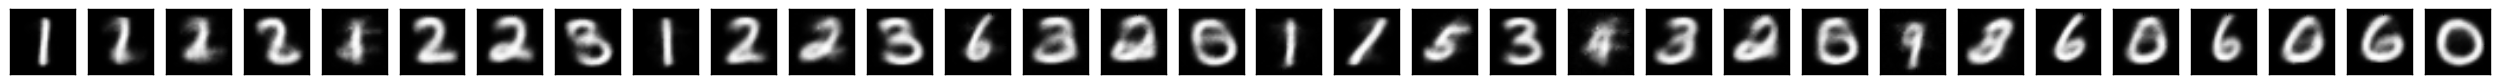

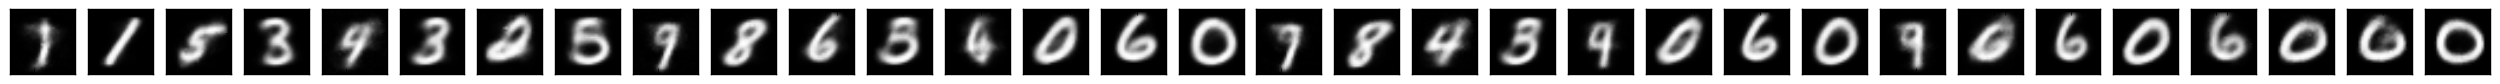

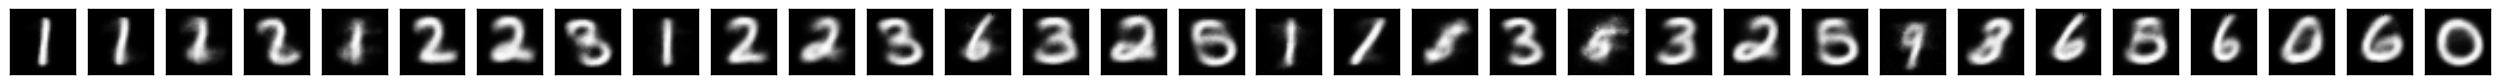

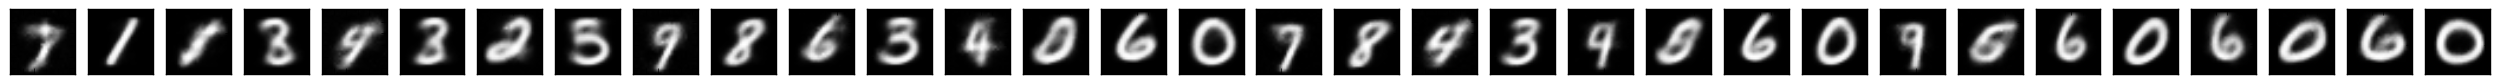

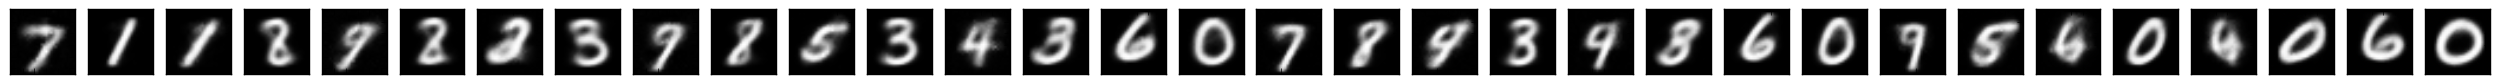

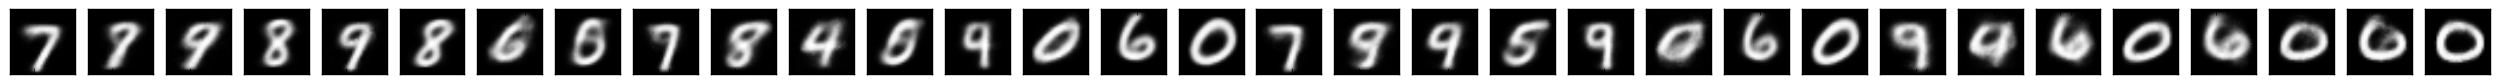

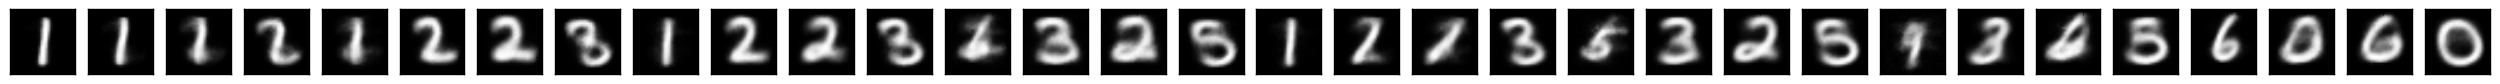

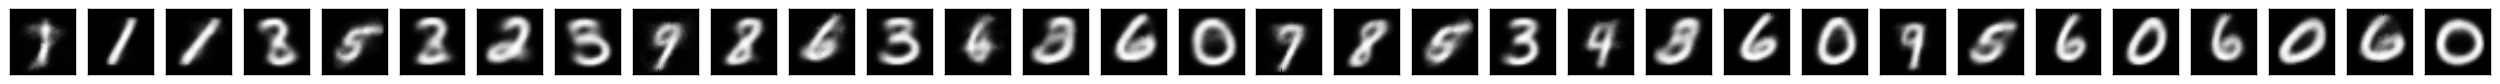

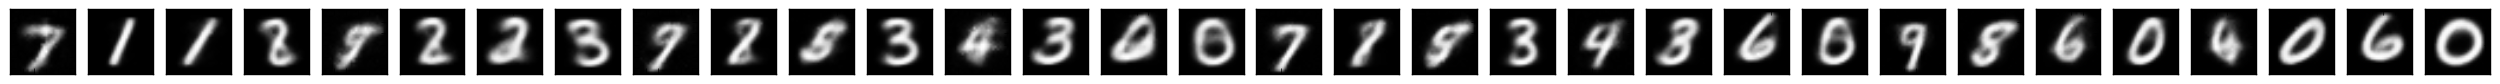

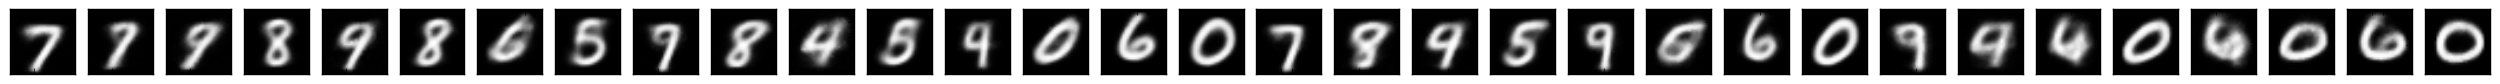

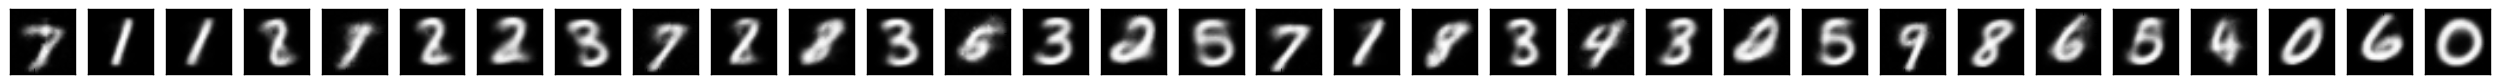

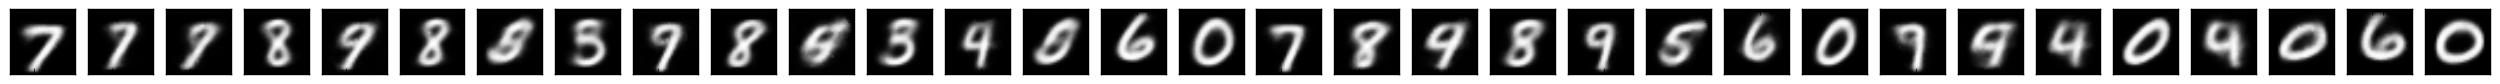

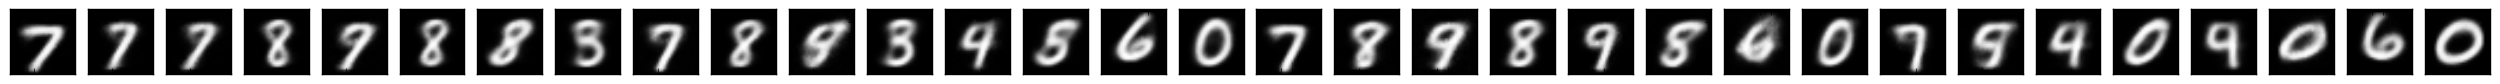

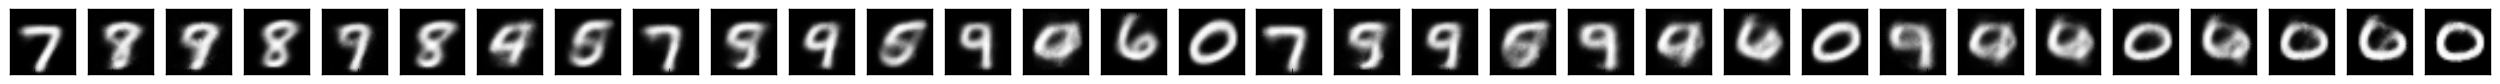

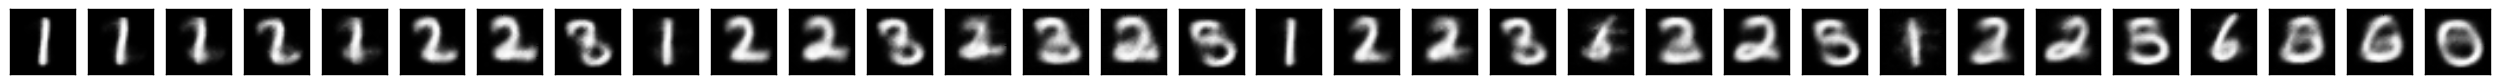

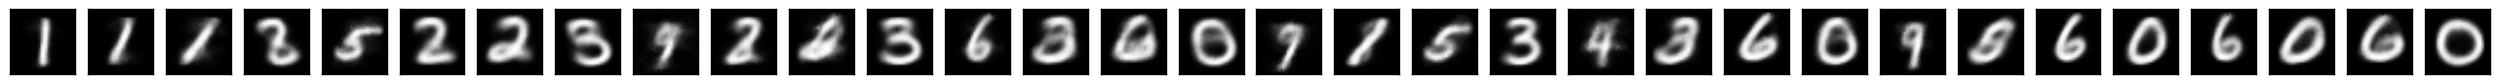

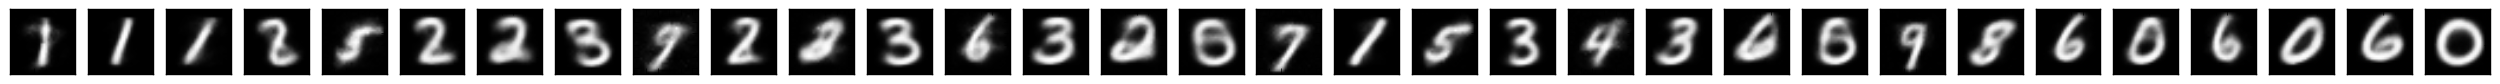

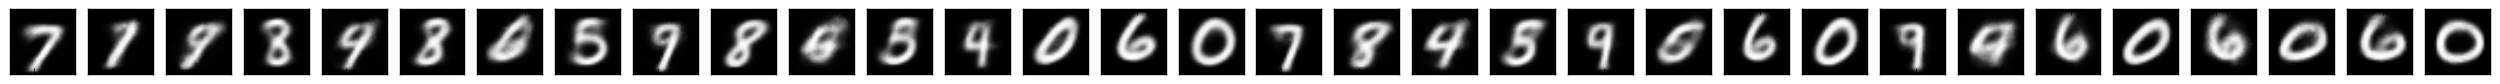

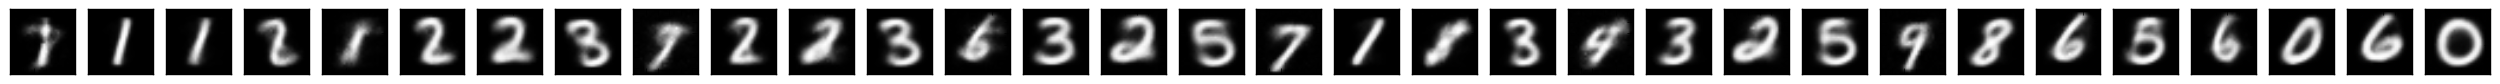

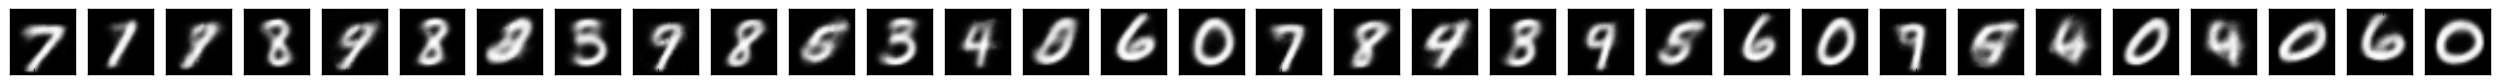

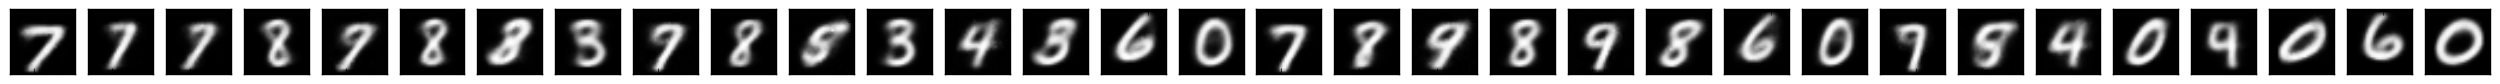

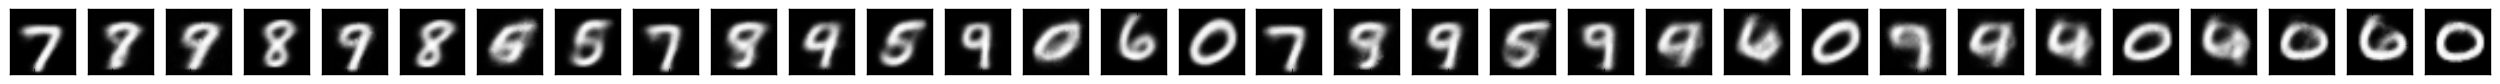

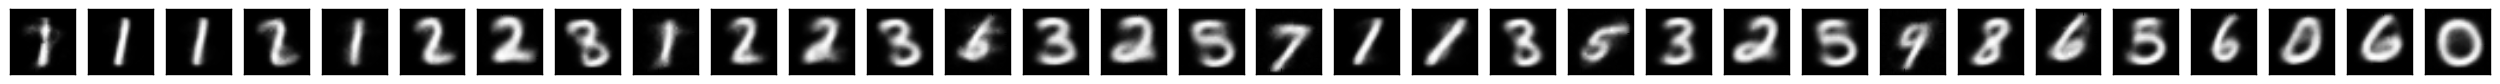

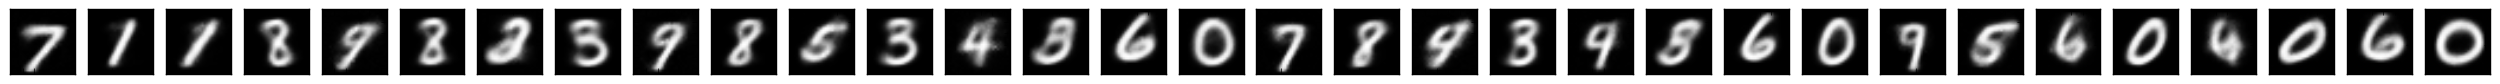

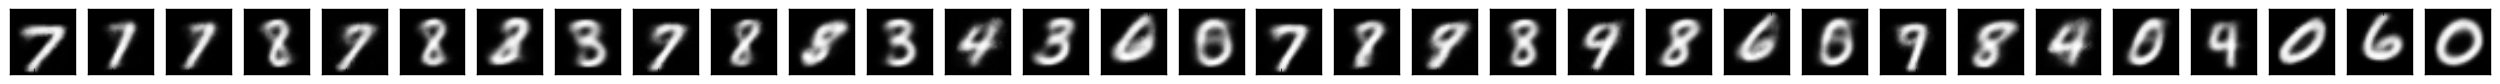

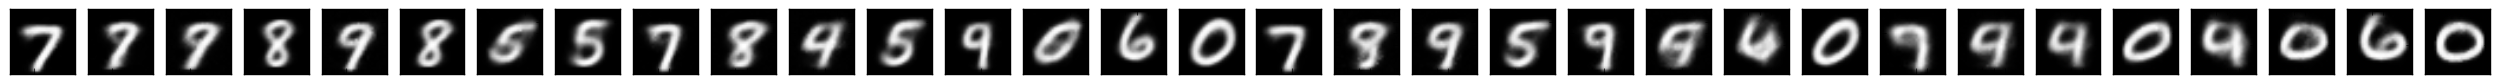

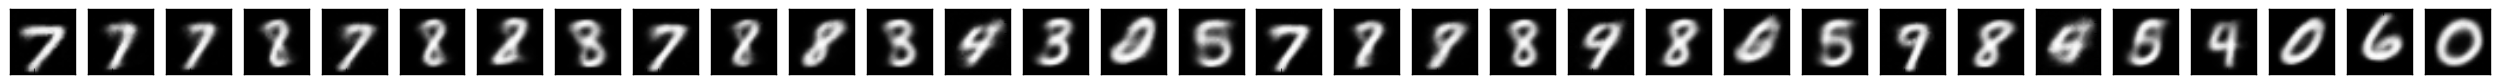

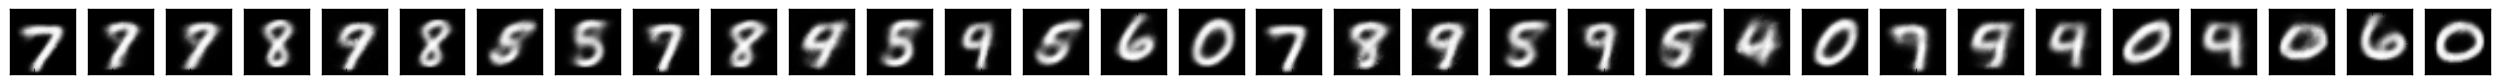

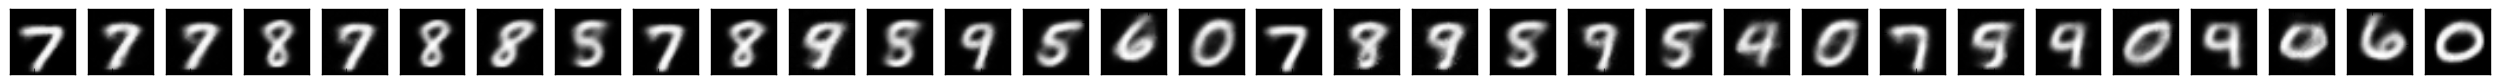

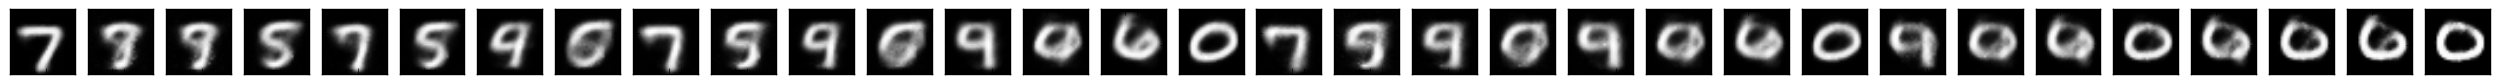

In [65]:
'''
convert = chainer.dataset.convert.concat_examples
d = convert(test[:10])
d = chainer.Variable(model.xp.array(d.tolist(), np.float32), volatile='auto')
generate_data(model, d, train=False, printer=True)
'''
plt.clf()
plt.close('all')
#message = np.array([0, 0, 0, 0, 0, 1, 1, 1, 0, 1]).astype('i')[:, None]
#generate(model, message)
import itertools
all_message = list(sorted(itertools.product([0, 1], repeat=10)))
all_message = [list(m[::-1]) for m in all_message]
print('to', all_message[-1])
ran = len(all_message) // 32
for i in range(ran):
    message = all_message[len(all_message)//ran*i: len(all_message)//ran*(i+1)]
    message = np.array(message).astype('i').T
    generate(model, message, printer=False)

"""
message = np.array([
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
            [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
    ]).astype('i').T
"""
#generate(model, message)

#message = 1 - message
#generate(model, message)

In [66]:
all_message[:10]

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 0, 0, 0, 0, 0, 0]]

In [68]:
(all_message[10],
all_message[42],
all_message[74])

([0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
 [0, 1, 0, 1, 0, 0, 1, 0, 0, 0])